<h1>Temperature Control v1 Model Training</h1>

<h3>Load Libraries</h3>

In [133]:
import pandas as pd
import glob
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

<h3>Data Loading and Preprocessing</h3>

In [134]:
import pandas as pd

# Load the combined climate and device data
climate_data = pd.read_csv('training/clean/combined_climate_data.csv')
device_data = pd.read_csv('training/clean/combined_device_data.csv')

# Convert the 'Time' and 'time' columns to datetime format
climate_data['Time'] = pd.to_datetime(climate_data['Time'])
device_data['time'] = pd.to_datetime(device_data['time'])

# Merge the datasets on the timestamp
merged_df = pd.merge(device_data, climate_data, left_on='time', right_on='Time', how='inner')

# Drop the redundant 'Time' column
merged_df.drop(columns=['Time'], inplace=True)

# Add time-based features
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['day'] = merged_df['time'].dt.day
merged_df['month'] = merged_df['time'].dt.month

# Check for NaN values
print("NaN values in merged_df:\n", merged_df.isna().sum())

# Drop rows with NaN values or handle them appropriately
merged_df = merged_df.dropna()

# Print the merged dataframe
print(merged_df.head())
print("Column names:", merged_df.columns)

# Select features and target variable
features = ['Temperature', 'Humidity', 'hour', 'day', 'month', 'temperature']  # Include device temperature in features
target = 'temperature'


NaN values in merged_df:
 time           0
temperature    1
Temperature    0
Humidity       0
hour           0
day            0
month          0
dtype: int64
                       time  temperature  Temperature  Humidity  hour  day  \
0 2023-03-15 15:00:00+08:00    20.238870           31      0.52    15   15   
1 2023-03-15 16:00:00+08:00    20.248299           31      0.52    16   15   
2 2023-03-15 17:00:00+08:00    20.249218           30      0.55    17   15   
3 2023-03-15 18:00:00+08:00    20.248273           30      0.59    18   15   
4 2023-03-15 19:00:00+08:00    20.172554           29      0.58    19   15   

   month  
0      3  
1      3  
2      3  
3      3  
4      3  
Column names: Index(['time', 'temperature', 'Temperature', 'Humidity', 'hour', 'day',
       'month'],
      dtype='object')


In [135]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale the features and target separately
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_features = feature_scaler.fit_transform(merged_df[features])
scaled_target = target_scaler.fit_transform(merged_df[[target]])

# Check for NaN values in scaled features and target
print("NaN values in scaled_features:", np.isnan(scaled_features).sum())
print("NaN values in scaled_target:", np.isnan(scaled_target).sum())

# Prepare sequences for LSTM
def create_sequences(features, target, seq_length):
    xs = []
    ys = []
    for i in range(len(features) - seq_length):
        x = features[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(scaled_features, scaled_target, seq_length)

# Check for NaN values in sequences
print("NaN values in X:", np.isnan(X).sum())
print("NaN values in y:", np.isnan(y).sum())

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], seq_length, len(features)))
X_test = X_test.reshape((X_test.shape[0], seq_length, len(features)))

# Check for NaN values in training and testing sets
print("NaN values in X_train:", np.isnan(X_train).sum())
print("NaN values in X_test:", np.isnan(X_test).sum())
print("NaN values in y_train:", np.isnan(y_train).sum())
print("NaN values in y_test:", np.isnan(y_test).sum())


NaN values in scaled_features: 0
NaN values in scaled_target: 0
NaN values in X: 0
NaN values in y: 0
NaN values in X_train: 0
NaN values in X_test: 0
NaN values in y_train: 0
NaN values in y_test: 0


In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a more complex LSTM model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),  # Increased number of units
    Dropout(0.3),  # Increased dropout rate
    LSTM(64, activation='relu'),  # Second LSTM layer with more units
    Dropout(0.3),  # Increased dropout rate
    Dense(32, activation='relu'),  # Added a Dense layer
    Dense(1)  # Output layer
])

# Compile the model with a different optimizer and learning rate
optimizer = Adam(learning_rate=0.001)  # Specifying learning rate
model.compile(optimizer=optimizer, loss='mse')

# Train the model with modified batch size and number of epochs
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)


Epoch 1/25
15/15 [==============================] - 2s 32ms/step - loss: 0.1394 - val_loss: 0.0810
Epoch 2/25
15/15 [==============================] - 0s 22ms/step - loss: 0.0752 - val_loss: 0.0608
Epoch 3/25
15/15 [==============================] - 0s 22ms/step - loss: 0.0574 - val_loss: 0.0401
Epoch 4/25
15/15 [==============================] - 0s 22ms/step - loss: 0.0437 - val_loss: 0.0372
Epoch 5/25
15/15 [==============================] - 0s 21ms/step - loss: 0.0401 - val_loss: 0.0377
Epoch 6/25
15/15 [==============================] - 0s 21ms/step - loss: 0.0372 - val_loss: 0.0321
Epoch 7/25
15/15 [==============================] - 0s 22ms/step - loss: 0.0364 - val_loss: 0.0277
Epoch 8/25
15/15 [==============================] - 0s 22ms/step - loss: 0.0329 - val_loss: 0.0350
Epoch 9/25
15/15 [==============================] - 0s 21ms/step - loss: 0.0311 - val_loss: 0.0305
Epoch 10/25
15/15 [==============================] - 0s 22ms/step - loss: 0.0291 - val_loss: 0.0262
Epoch 11/

In [137]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Define the LSTM model with modified hyperparameters
# model = Sequential([
#     LSTM(100, activation='tanh', return_sequences=True, input_shape=(seq_length, len(features))),  # Increased number of units, return sequences for stacking layers
#     Dropout(0.2),  # Adding dropout for regularization
#     LSTM(50, activation='tanh'),  # Second LSTM layer
#     Dropout(0.2),  # Adding dropout for regularization
#     Dense(1)  # Output layer
# ])

# # Compile the model with a different optimizer and learning rate
# optimizer = Adam(learning_rate=0.001)  # Specifying learning rate
# model.compile(optimizer=optimizer, loss='mse')

# # Train the model with modified batch size and number of epochs
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


In [138]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict on test data
y_pred = model.predict(X_test)

# Inverse scale the predictions and target values
y_pred = target_scaler.inverse_transform(y_pred)
y_test = target_scaler.inverse_transform(y_test)

# Check for NaN values in predictions
print(f"NaN in y_pred: {np.isnan(y_pred).sum()}")

# Remove NaN values
mask = ~np.isnan(y_pred).flatten()
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred[mask]

# Debugging: Check shapes of y_test_filtered and y_pred_filtered
print("y_test_filtered shape:", y_test_filtered.shape)
print("y_pred_filtered shape:", y_pred_filtered.shape)

# Calculate mean absolute error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
print(f'Mean Absolute Error: {mae}')


5/5 [==============================] - 0s 5ms/step - loss: 0.0306
Test Loss: 0.030605453997850418
5/5 [==============================] - 0s 4ms/step
NaN in y_pred: 0
y_test_filtered shape: (146, 1)
y_pred_filtered shape: (146, 1)
Mean Absolute Error: 1.2136931876963493


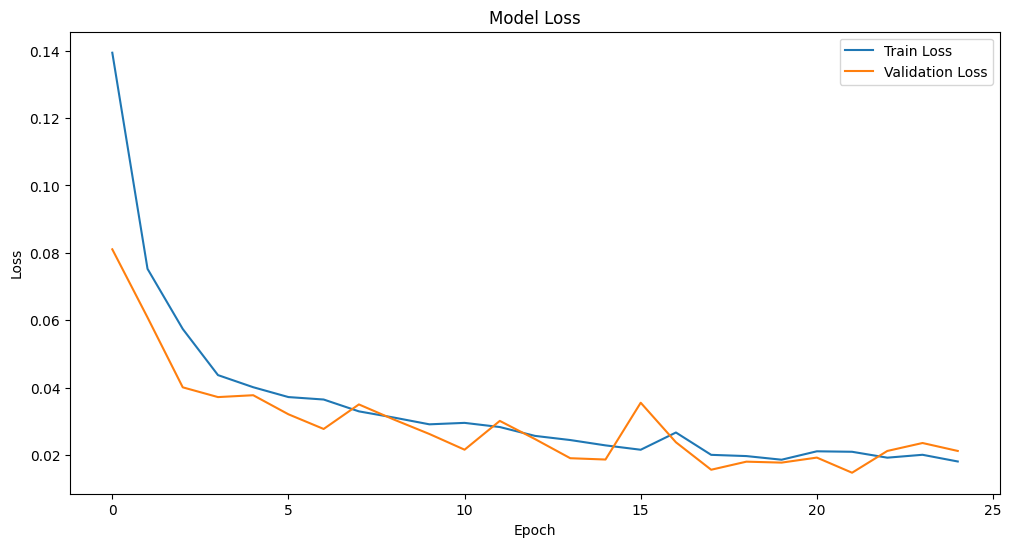

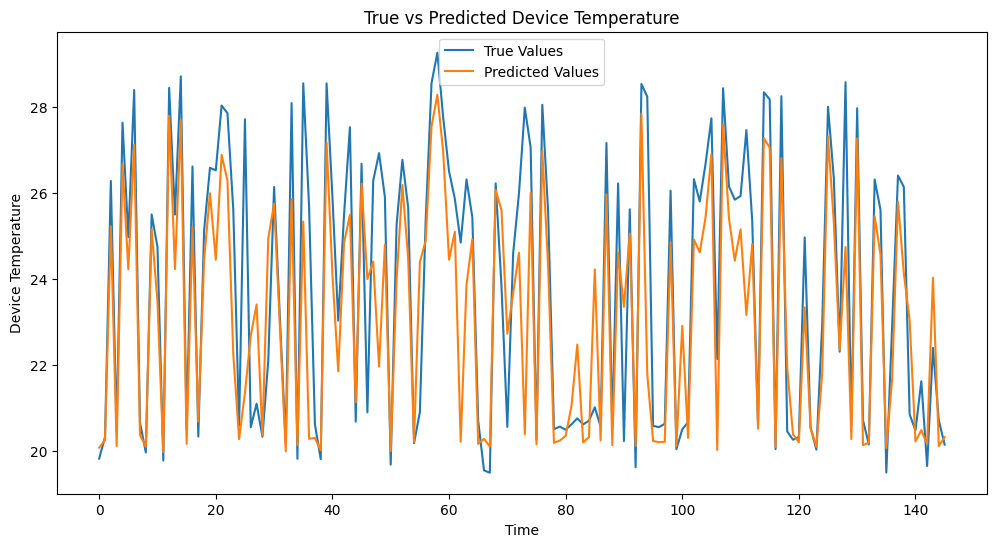

In [139]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot true vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_filtered, label='True Values')
plt.plot(y_pred_filtered, label='Predicted Values')
plt.title('True vs Predicted Device Temperature')
plt.xlabel('Time')
plt.ylabel('Device Temperature')
plt.legend()
plt.show()
